In [536]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [537]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn

In [538]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [539]:
df  = pd.read_csv("DR18_dataset_and_PRF/DR18_SDSS_query_data.csv")
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [540]:
#Removing rows with redshift error greater (lesser) than 1 (-1) and greater than the redshift itself
df = df.drop(df[(df['zErr'] > 1) |  (df['zErr'] < -1) & (df['zErr'] >df['redshift'])].index)
print(df.shape[0])

99917


In [541]:
#Numericall represent the class since it is in string format
LE = LabelEncoder()
df['class'] = LE.fit_transform(df['class'])
df['class'].value_counts()

class
0    52322
2    37209
1    10386
Name: count, dtype: int64

In [542]:
X = df[['u','g','r', 'i', 'z','redshift']]#,'r', 'i', 'z','redshift'
y = df['class']

In [543]:
#To balance the data
sm = SMOTE(random_state = 30, k_neighbors = 5) 
X, y = sm.fit_resample(X, y)
y.value_counts()

class
0    52322
1    52322
2    52322
Name: count, dtype: int64

In [544]:
y

0         0
1         0
2         0
3         0
4         0
         ..
156961    2
156962    2
156963    2
156964    2
156965    2
Name: class, Length: 156966, dtype: int64

In [545]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [546]:
X,X.shape

(array([[ 1.05911238e+00,  4.50253589e-01,  1.38146212e-01,
          1.53630503e-03,  8.41681534e-04, -4.43235275e-01],
        [-9.97815115e-01, -7.08653593e-01, -6.08352857e-01,
         -2.75906641e-02, -1.42423144e-02, -5.80484047e-01],
        [ 9.71666937e-01,  2.42776149e-01,  3.72480353e-02,
         -3.96803013e-04, -1.69046399e-04, -5.35414504e-01],
        ...,
        [ 1.11455149e+00,  5.29959242e-01,  3.71869958e-01,
          2.11549208e-02,  1.62070688e-02, -6.11205966e-01],
        [-1.02345620e+00, -9.01565919e-01, -6.33389736e-01,
         -2.40444254e-02, -7.92968703e-03, -6.12550859e-01],
        [ 9.09671938e-01, -5.70144493e-02, -3.02100254e-01,
         -1.53916324e-02, -6.39833794e-03, -6.12563092e-01]]),
 (156966, 6))

In [547]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [548]:
neurons = 20
class BNN(nn.Module):
    def __init__(self):
        super(BNN, self).__init__()
        self.fc1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=X.shape[1], out_features=neurons)
        #torch.nn.Dropout(p=0.2)
        self.fc2 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=neurons, out_features=neurons)
        #torch.nn.Dropout(p=0.2)
        self.fc3 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=neurons, out_features=3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [549]:
model = BNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
kl_weight = 0.01 # KL divergence weight for Bayesian layers

In [550]:
losses=[]
epochs = 500
for epoch in range(epochs+1):
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    kl_loss = bnn.functional.bayesian_kl_loss(model.fc1) + bnn.functional.bayesian_kl_loss(model.fc2) + bnn.functional.bayesian_kl_loss(model.fc3)
    
    total_loss = loss + kl_weight * kl_loss
    
    losses.append(loss.detach().numpy())

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [0/500], Loss: 1.1762
Epoch [10/500], Loss: 0.6098
Epoch [20/500], Loss: 0.6128
Epoch [30/500], Loss: 0.5175
Epoch [40/500], Loss: 0.4889
Epoch [50/500], Loss: 0.4478
Epoch [60/500], Loss: 0.4521
Epoch [70/500], Loss: 0.4198
Epoch [80/500], Loss: 0.4190
Epoch [90/500], Loss: 0.5036
Epoch [100/500], Loss: 0.3313
Epoch [110/500], Loss: 0.3631
Epoch [120/500], Loss: 0.3011
Epoch [130/500], Loss: 0.4281
Epoch [140/500], Loss: 0.3138
Epoch [150/500], Loss: 0.3107
Epoch [160/500], Loss: 0.2729
Epoch [170/500], Loss: 0.2505
Epoch [180/500], Loss: 0.2220
Epoch [190/500], Loss: 0.3113
Epoch [200/500], Loss: 0.2552
Epoch [210/500], Loss: 0.2346
Epoch [220/500], Loss: 0.2491
Epoch [230/500], Loss: 0.2690
Epoch [240/500], Loss: 0.2436
Epoch [250/500], Loss: 0.2462
Epoch [260/500], Loss: 0.2830
Epoch [270/500], Loss: 0.2020
Epoch [280/500], Loss: 0.1971
Epoch [290/500], Loss: 0.1864
Epoch [300/500], Loss: 0.1965
Epoch [310/500], Loss: 0.1821
Epoch [320/500], Loss: 0.2220
Epoch [330/500], Loss

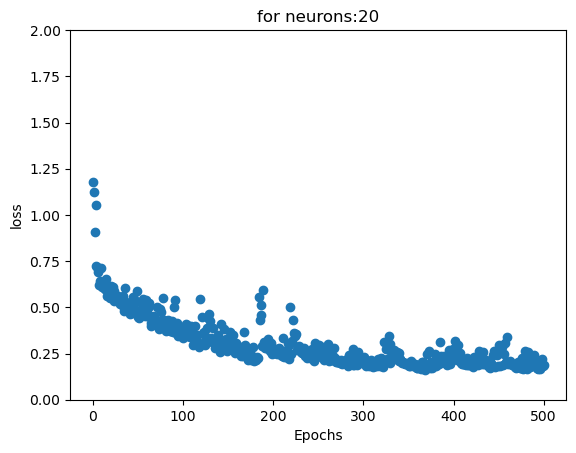

In [551]:
plt.scatter(range(epochs+1),np.asarray(losses))
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.title(f"for neurons:{neurons}")
plt.ylim(0,2)
plt.show()

In [552]:
model.eval()
with torch.no_grad():
    num_samples = 200
    y_pred_samples = []

    for _ in range(num_samples):
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        y_pred_samples.append(predicted)

    y_pred_samples = torch.stack(y_pred_samples).numpy()

    accuracies = [accuracy_score(y_test.numpy(), y_pred_samples[i]) for i in range(num_samples)]
    mean_accuracy = np.mean(accuracies)
    uncertainty_accuracy = np.std(accuracies)

    
    confusion_matrices = [confusion_matrix(y_test.numpy(), y_pred_samples[i]) for i in range(num_samples)]
    confusion_mat = np.asarray(confusion_matrices)
    percentage_confusion_matrix = confusion_mat.astype('float')


    for j in range(num_samples):
        for k in range(len(confusion_mat[j])):
            row_sum = np.sum(confusion_mat[j][k])
            percentage_confusion_matrix[j][k] = np.round((confusion_mat[j][k] / row_sum) * 100,4)

    
    

mean_confusion_matrix = np.mean(percentage_confusion_matrix, axis=0) #mean of the percentages
uncertainty_confusion_matrix = np.std(percentage_confusion_matrix, axis=0) #std of the percentages

print()  
print(f"Mean Accuracy: {mean_accuracy*100:.2f}%")
print(f"Accuracy Uncertainty: {uncertainty_accuracy*100:.2f}%")
print(f"Accuracy: {mean_accuracy*100:.2f}+/-{uncertainty_accuracy*100:.2f}%")


Mean Accuracy: 94.91%
Accuracy Uncertainty: 0.48%
Accuracy: 94.91+/-0.48%


In [553]:
"""
kl_weight = 0.01
neurons = 10, Accuracy: 91.43+/-0.53%
neurons = 20, Accuracy: 95.07+/-0.81%

when neuron = 30, sometimes the accuracy is high ~95% and sometimes it is below 90% or even 80%. This could be due to overfitting 
caused by high number of neurons

kl_weight = 0.0001, neurons = 15
A kl_weight that low results in an Accuracy: 98.01+/-0.03%. However, this may lead to poor generalization. 
"""

'\nkl_weight = 0.01\nneurons = 10, Accuracy: 91.43+/-0.53%\nneurons = 20, Accuracy: 95.07+/-0.81%\n\nwhen neuron = 30, sometimes the accuracy is high ~95% and sometimes it is below 90% or even 80%. This could be due to overfitting \ncaused by high number of neurons\n\nkl_weight = 0.0001\nA kl_weight that low results in an Accuracy: 98.01+/-0.03%. However, this may lead to poor generalization. \n'

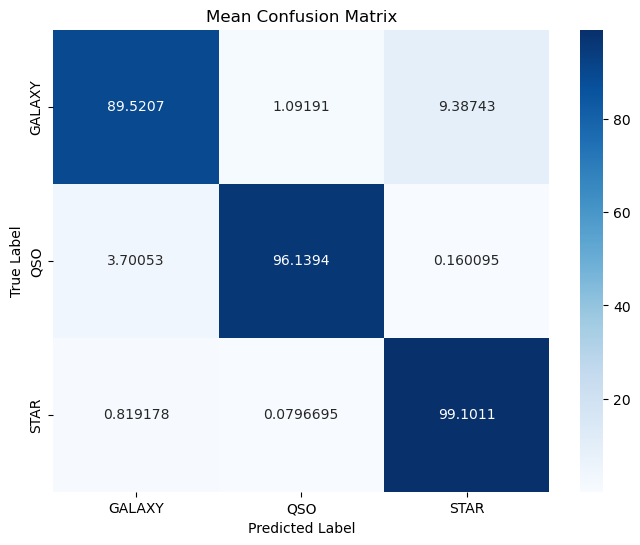

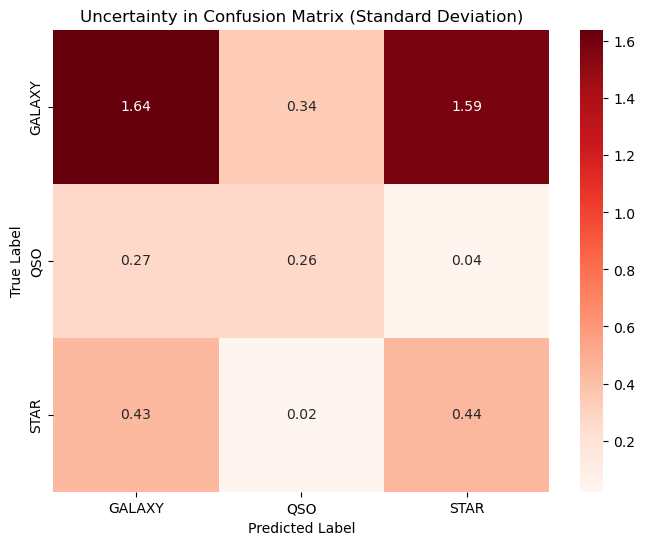

In [554]:
plt.figure(figsize=(8, 6))
sns.heatmap(mean_confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=True, xticklabels=sorted(LE.inverse_transform(y_test.unique())), yticklabels=sorted(LE.inverse_transform(y_test.unique())))
plt.title('Mean Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


plt.figure(figsize=(8, 6))
sns.heatmap(uncertainty_confusion_matrix, annot=True, fmt='.2f', cmap='Reds', cbar=True, xticklabels=sorted(LE.inverse_transform(y_test.unique())), yticklabels=sorted(LE.inverse_transform(y_test.unique())))
plt.title('Uncertainty in Confusion Matrix (Standard Deviation)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()